<a href="https://colab.research.google.com/github/maidacundo/DeepLearningREPO/blob/main/Soluzione3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Dense, MaxPooling2D, Add, Dropout, ConvLSTM2D, GaussianNoise, BatchNormalization , Activation, UpSampling2D, Resizing, UpSampling3D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

In [19]:
(x_train_blured, x_train), (x_test_blured, x_test) = getDataset()
print(f"Train size: {x_train_blured.shape}. Test size: {x_test_blured.shape}")

Train size: (50000, 32, 32, 3). Test size: (10000, 32, 32, 3)


In [20]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, LogCosh
import typing


class ConvNet:
    """Abstract class representing a generic Convolutional Neural Network"""

    def __init__(self):
        self.model = None

    def compile(self,
                lr: float = 1e-4,
                loss: str = 'mse',
                use_nesterov: bool = False):

        loss_dict = dict({
            'mse': MeanSquaredError(),
            'mae': MeanAbsoluteError(),
            'logcosh': LogCosh()
        })

        metric_list = [ssim,
                       psnr,
                       'mse',
                       'mae',
                       'accuracy']

        if use_nesterov:
            optimizer = Nadam(learning_rate=lr)
        else:
            optimizer = Adam(learning_rate=lr)

        self.model.compile(optimizer,
                           loss=loss_dict[loss],
                           metrics=metric_list)

    def fit(self,
            x: typing.Optional = None,
            y: typing.Optional = None,
            batch_size: int = 32,
            epochs: int = 1,
            steps_per_epoch: typing.Optional[int] = None,
            validation_data: typing.Optional = None,
            validation_steps: typing.Optional[int] = None,
            initial_epoch: int = 0,
            callbacks: typing.Optional[typing.List[Callback]] = None):
        if y is not None:
            return self.model.fit(x, y,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=validation_data,
                                  initial_epoch=initial_epoch,
                                  callbacks=callbacks)
        else:
            return self.model.fit(x,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=validation_data,
                                  validation_steps=validation_steps,
                                  initial_epoch=initial_epoch,
                                  callbacks=callbacks)

    def evaluate(self,
                 x: typing.Optional = None,
                 y: typing.Optional = None,
                 batch_size: typing.Optional[int] = None,
                 steps: typing.Optional[int] = None):
        if y is not None:
            return self.model.evaluate(x, y, batch_size=batch_size, steps=steps)
        else:
            return self.model.evaluate(x, batch_size=batch_size, steps=steps)

    def predict(self, X):
        return self.model.predict(X)

    def summary(self):
        self.model.summary()

    def plot_model(self, path):
        plot_model(self.model, to_file=path, show_shapes=True)

In [21]:
def res_block(x, filter, kernel_size):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, kernel_size, padding = 'same')(x)
    # x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, kernel_size, padding = 'same')(x)
    # x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Layer, Conv2D, Conv2DTranspose, Add, ELU, ReLU,
                                     BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import logcosh
import typing


def encode(in_layer: Layer,
           num_layers: int = 15,
           filters: int = 64,
           kernel_size: int = 3,
           strides: int = 1,
           padding: str = 'same',
           use_elu: bool = True,
           bn_before_act: bool = False) -> typing.List[Layer]:
    layers = []
    x = in_layer
    for i in range(num_layers):
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding=padding,
                   name='encode_conv{:d}'.format(i))(x)
        if bn_before_act:
            x = BatchNormalization(name='encode_bn{:d}'.format(i))(x)
            if use_elu:
                x = ELU(name='encode_act{:d}'.format(i))(x)
            else:
                x = ReLU(name='encode_act{:d}'.format(i))(x)
        else:
            if use_elu:
                x = ELU(name='encode_act{:d}'.format(i))(x)
            else:
                x = ReLU(name='encode_act{:d}'.format(i))(x)
            x = BatchNormalization(name='encode_bn{:d}'.format(i))(x)
        layers.append(x)
    return layers


def decode(res_layers: typing.List[Layer],
           num_layers: int = 15,
           filters: int = 64,
           kernel_size: int = 3,
           strides: int = 1,
           padding: str = 'same',
           use_elu: bool = True,
           bn_before_act: bool = False) -> typing.List[Layer]:
    layers = []
    res_layers.reverse()
    x = res_layers[0]
    for i in range(num_layers):
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding=padding,
                   name='decode_conv{:d}'.format(i))(x)
        if i % 2 != 0:
            x = Add(name='decode_skip{:d}'.format(i))([x, res_layers[i]])
        if bn_before_act:
            x = BatchNormalization(name='decode_bn{:d}'.format(i))(x)
            if use_elu:
                x = ELU(name='decode_act{:d}'.format(i))(x)
            else:
                x = ReLU(name='decode_act{:d}'.format(i))(x)
        else:
            if use_elu:
                x = ELU(name='decode_act{:d}'.format(i))(x)
            else:
                x = ReLU(name='decode_act{:d}'.format(i))(x)
            x = BatchNormalization(name='decode_bn{:d}'.format(i))(x)
        layers.append(x)

    return layers


class REDNet10(ConvNet):
    def __init__(self, input_shape: typing.Tuple[int, int, int]):
        super(REDNet10, self).__init__()
        # ENCODER
        visible = Input(input_shape)
        encode_layers = encode(visible, num_layers=5)
        # DECODER
        decode_layers = decode(encode_layers, num_layers=5)
        output = Conv2DTranspose(filters=3,
                                 kernel_size=1,
                                 strides=1,
                                 padding='same',
                                 name='output_conv')(decode_layers[-1])
        output = Add(name='output_skip')([output, visible])
        output = ELU(name='output_elu')(output)

        self.model = Model(inputs=visible, outputs=output)


class REDNet20(ConvNet):
    def __init__(self, input_shape: typing.Tuple[int, int, int]):
        super(REDNet20, self).__init__()
        # ENCODER
        visible = Input(input_shape)
        encode_layers = encode(visible, num_layers=10)
        # DECODER
        decode_layers = decode(encode_layers, num_layers=10)
        output = Conv2DTranspose(filters=3,
                                 kernel_size=1,
                                 strides=1,
                                 padding='same',
                                 name='output_conv')(decode_layers[-1])
        output = Add(name='output_skip')([output, visible])
        output = ELU(name='output_elu')(output)

        self.model = Model(inputs=visible, outputs=output)


class REDNet30(ConvNet):
    def __init__(self,
                 input_shape: typing.Tuple[int, int, int],
                 bn_before_act: bool = False):
        super(REDNet30, self).__init__()
        # ENCODER
        visible = Input(input_shape)
        encode_layers = encode(visible,
                               bn_before_act=bn_before_act)
        # DECODER
        decode_layers = decode(encode_layers,
                               bn_before_act=bn_before_act)
        output = Conv2DTranspose(filters=3,
                                 kernel_size=1,
                                 strides=1,
                                 padding='same',
                                 name='output_conv')(decode_layers[-1])
        output = Add(name='output_skip')([output, visible])
        output = ELU(name='output_elu')(output)

        self.model = Model(inputs=visible, outputs=output)

In [26]:
input_shape = (32, 32, 3)
conv_net = REDNet30(input_shape)

In [27]:
conv_net.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 encode_conv0 (Conv2D)          (None, 32, 32, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 encode_act0 (ELU)              (None, 32, 32, 64)   0           ['encode_conv0[0][0]']           
                                                                                                  
 encode_conv1 (Conv2D)          (None, 32, 32, 64)   36928       ['encode_act0[0][0]']            
                                                                                            

In [29]:
conv_net.model.compile(loss='mse', optimizer='adam',metrics=['acc'])

hist = conv_net.model.fit(x_train_blured.reshape(-1, 32, 32, 3), 
          x_train.reshape(-1, 32, 32, 3), 
          epochs=20, 
          batch_size=34,
          validation_data=(x_test_blured, x_test))

Epoch 1/20
1471/1471 [==============================] - 58s 38ms/step - loss: 0.0179 - acc: 0.7573 - val_loss: 0.0051 - val_acc: 0.7774
Epoch 2/20
1471/1471 [==============================] - 56s 38ms/step - loss: 0.0047 - acc: 0.7800 - val_loss: 0.0040 - val_acc: 0.7928
Epoch 3/20
1471/1471 [==============================] - 55s 38ms/step - loss: 4.9299 - acc: 0.6323 - val_loss: 2.2434 - val_acc: 0.5086
Epoch 4/20
1471/1471 [==============================] - 55s 38ms/step - loss: 2.2341 - acc: 0.5094 - val_loss: 2.2434 - val_acc: 0.5086
Epoch 5/20
1471/1471 [==============================] - 56s 38ms/step - loss: 2.2341 - acc: 0.5094 - val_loss: 2.2434 - val_acc: 0.5086
Epoch 6/20
 453/1471 [========>.....................] - ETA: 36s - loss: 2.2390 - acc: 0.5096

KeyboardInterrupt: ignored

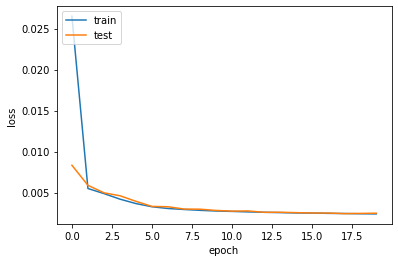

In [9]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(hist,['loss','val_loss'])

In [12]:
from tensorflow.keras.losses import MeanSquaredError

y_true = x_test
y_pred = conv_net.model.predict(x_test_blured)

mse = MeanSquaredError()
mse(y_true, y_pred).numpy()

#0.0023

#0.0041738243220982366
#0.004219622105503972
#0.00404854369862134
#0.003909846398674108
#0.00379532259022029
#0.003393252
#0.0026358136
# 0.0024754216

0.0024754216

Original Images


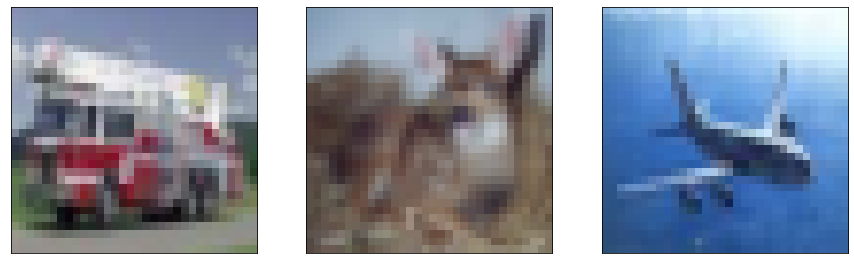

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Blurred Images


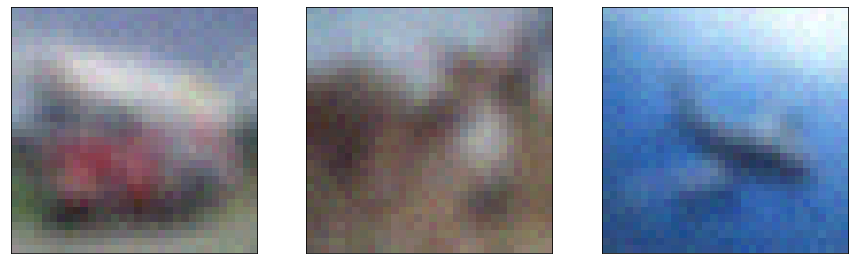

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Images


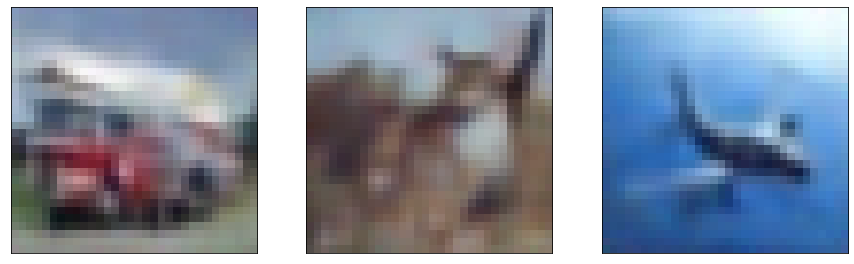

In [11]:
#utility function to pick samples to be tested

def get_samples(arr, n):
    temp = random.sample(range(len(arr)), n)
    result = arr[temp]
    return result, temp

num = 3
figsize = 15
org, temp = get_samples(x_test, num)
blur = x_test_blured[temp]
preds = conv_net.model.predict(blur.reshape(-1, 32, 32, 3))
#plotting results
plt.figure(figsize = (figsize, figsize))
print('Original Images')
for i in range(num):
    plt.subplot(1, num, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(org[i])
plt.show()
plt.figure(figsize = (figsize, figsize))
print('Blurred Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(blur[i])
plt.show()
plt.figure(figsize = (figsize, figsize))
print('Predicted Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i])
plt.show()